In [1]:
import os
import sys
sys.path.insert(0,'/home/junwoony/Desktop/Differentiable_Optimization_GCN/Differentiable_Optimization_GCN/')

import numpy as np
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1
%env CUDA_LAUNCH_BLOCKING=1

import mongo
import time
import pickle
import random
import numpy as np
import tqdm
import copy
import matplotlib.pyplot as plt
import multiprocess as mp

from pymatgen.io.ase import AseAtomsAdaptor

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lbfgs import LBFGS
from cgcnn.data_orbital import StructureData, ListDataset, StructureDataTransformer, collate_pool, MergeDataset
from cgcnn.model import CrystalGraphConvNet

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.metrics import get_scorer
from skorch import NeuralNetRegressor
from skorch.callbacks import Checkpoint, LoadInitState #needs skorch 0.4.0, conda-forge version at 0.3.0 doesn't cut it
import skorch.callbacks.base
from skorch.dataset import CVSplit
from skorch.callbacks.lr_scheduler import WarmRestartLR, LRScheduler

from utils.adamwr.adamw import AdamW
from utils.adamwr.cosine_scheduler import CosineLRWithRestarts


from sigopt_sklearn.search import SigOptSearchCV


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1
env: CUDA_LAUNCH_BLOCKING=1


In [2]:
# SDT_list = pickle.load(open('../../../cgcnn/bond_regression3/new2/SDT_list.pkl', 'rb'))
docs = pickle.load(open('../../../cgcnn/bond_regression3/new2/final_docs.pkl', 'rb'))
docs_test_surface = pickle.load(open('./new_backup/docs_test_surface.pkl', 'rb'))

# structures = SDT_list[0]
# orig_atom_fea_len = structures[0].shape[-1]
# nbr_fea_len = structures[1].shape[-1]

# docs_test = pickle.load(open('./new_backup/docs_test.pkl','rb'))

# target_list = np.array([sdt[-1][sdt[9]].numpy() for sdt in SDT_list]).reshape(-1,1) #get final_pos of free atoms ONLY

In [3]:
# SDT_training, SDT_test, target_training, target_test, docs_training, docs_test \
# = train_test_split(SDT_list, target_list, docs, test_size=0.1, random_state=42)

In [4]:
# natoms =[]
# types = []
# steps = []
# distances = []
# filtered_idx = []
# docs_test_new = []
# docs_test_surface, docs_test_slab = [], []
# for doc in docs_test:
#     natoms.append(doc['atoms']['natoms'])
#     types.extend(doc['atoms']['chemical_symbols'])
#     atoms = mongo.make_atoms_from_doc(doc, is_initial=True)
#     atoms_final = mongo.make_atoms_from_doc(doc, is_initial=False)
#     if atoms.constraints:
#         fixed_atom_idx = atoms.constraints[0].index
#         base = np.ones(len(atoms.positions))
#         base[fixed_atom_idx] = 0
#         free_atom_idx = np.where(base==1)[0]
        
#     else:
#         free_atom_idx = np.arange(len(atoms))
#     difference = atoms.positions[free_atom_idx] - atoms_final.positions[free_atom_idx]
#     dist = np.sqrt(np.sum(difference**2, axis=1))
#     if np.mean(dist) > 0.06:
# #         distances.append(dist)
# #         filtered_idx.append(doc['idx'])
#         if doc['data'] == 'surface':
#             docs_test_surface.append(doc['idx'])
#         elif doc['data'] == 'slab':
#             docs_test_slab.append(doc['idx'])


In [3]:
import ase
from ase.io import read, write
import glob


steps_initial, steps_test = [], []
E_initial, E_test = [], []
dist_changes = []
F_initial, F_test = [], []
test_final, initial_final =[], []
test_initial, initial_initial= [], []
dist_init, dist_test = [], []
i=0
total_atoms = 0
for idx in tqdm.tqdm(docs_test_surface):
    geom_initial = read('./new_backup/traj_surface/results_initial/%d_initial_vasprun.xml' %idx, index=':', format='vasp-xml')
    geom_test = read('./new_backup/traj_surface/results_test/%d_test_vasprun.xml' %idx, index=':', format='vasp-xml')

    c_initial, c_test = 0, 0
    force_initial, force_test = 10, 10
    
    ### Set max_force < 0.05 as a convergence rule ###
    while force_initial > 0.05:
        atom = geom_initial[c_initial]
        force_initial = np.max(np.abs(atom.get_forces()))
        c_initial += 1

    while force_test > 0.05:
        atom = geom_test[c_test]
        force_test = np.max(np.abs(atom.get_forces()))
        c_test += 1
    
    ### TO ensure the convergence to the same local minima ###
    if np.abs(geom_initial[c_initial-1].get_potential_energy() - geom_test[c_test-1].get_potential_energy()) < 0.2:
        steps_initial.append(c_initial)
        steps_test.append(c_test)
        

        atoms_initial = geom_initial[0]
        atoms_test = geom_test[0]

        if atoms_initial.constraints:
            fixed_atom_idx = atoms_initial.constraints[0].index
            base = np.ones(len(atoms_initial.positions))
            base[fixed_atom_idx] = 0
            free_atom_idx = np.where(base==1)[0]

        else:
            free_atom_idx = np.arange(len(atoms_initial))

        difference_test = geom_test[0].positions[free_atom_idx] - geom_test[-1].positions[free_atom_idx]
        

        test_final.append(geom_test[-1].get_scaled_positions()[free_atom_idx])
        initial_final.append(geom_initial[-1].get_scaled_positions()[free_atom_idx])
        test_initial.append(geom_test[0].get_scaled_positions()[free_atom_idx])
        initial_initial.append(geom_test[0].get_scaled_positions()[free_atom_idx])

        difference = atoms_initial.positions[free_atom_idx] - atoms_test.positions[free_atom_idx]
        dist = np.sqrt(np.sum(difference**2, axis=1))
        dist_changes.append(np.max(dist))

        difference_init = geom_initial[0].positions[free_atom_idx] - geom_initial[-1].positions[free_atom_idx]
        dist_init.append(np.mean(np.sqrt(np.sum(difference_init**2, axis=1))))

        difference_test = geom_test[0].positions[free_atom_idx] - geom_test[-1].positions[free_atom_idx]
        dist_test.append(np.mean(np.sqrt(np.sum(difference_test**2, axis=1))))


#         if c_initial - c_test == -58:
#             energies_initial, forces_initial = [],[]
#             energies_test, forces_test = [], []

#             for gm in geom_initial:
#                 energy = gm.get_potential_energy()
#                 force = np.max(gm.get_forces())
#                 energies_initial.append(energy)
#                 forces_initial.append(force)
#             for gm in geom_test:
#                 energy = gm.get_potential_energy()
#                 force = np.max(gm.get_forces())
#                 energies_test.append(energy)
#                 forces_test.append(force)

#             print(np.max(np.abs(geom_initial[c_initial-1].get_forces())), np.max(np.abs(geom_test[c_test-1].get_forces())))
#             print(geom_initial[-1].get_potential_energy() - geom_test[-1].get_potential_energy())
#             print(geom_initial[c_initial-1].get_potential_energy() - geom_test[c_test-1].get_potential_energy())



        E_initial.append(geom_initial[c_initial-1].get_potential_energy())
        E_test.append(geom_test[c_test-1].get_potential_energy())

        F_initial.append(np.max(np.abs(geom_initial[0].get_forces())))
        F_test.append(np.max(np.abs(geom_test[0].get_forces())))
        i +=1
# ##### IF we use F < 0.03,
#         steps_initial.append(len(geom_initial))
#         steps_test.append(len(geom_test))
        
            
steps_initial, steps_test = np.array(steps_initial), np.array(steps_test)
E_initial, E_test = np.array(E_initial), np.array(E_test)
dist_init, dist_test = np.array(dist_init), np.array(dist_test)

test_final = np.concatenate(test_final)
initial_final = np.concatenate(initial_final)
test_initial = np.concatenate(test_initial)
initial_initial = np.concatenate(initial_initial)

# write('trajectory.traj', geom, format='traj')

In [6]:
np.mean(np.abs(test_final - test_initial))

0.028522501413123364

In [7]:
np.mean(np.abs(initial_final - initial_initial))

0.03617101279790026

In [12]:
print(np.mean(dist_init), np.mean(dist_test))

0.14203136727137997 0.33743438443191587


In [4]:
print(np.mean(dist_init), np.mean(dist_test))

0.13836219750047846 0.3785617799217051


(array([128.,  29.,  17.,  15.,   8.,   4.,   4.,   1.,   0.,   1.]),
 array([0.00504877, 0.29384299, 0.5826372 , 0.87143141, 1.16022563,
        1.44901984, 1.73781405, 2.02660826, 2.31540248, 2.60419669,
        2.8929909 ]),
 <a list of 10 Patch objects>)

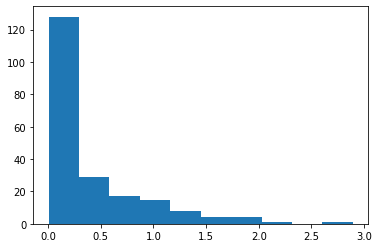

In [6]:
plt.hist(dist_test)

In [7]:
bad_idx = np.where(dist_test > 0.5)[0]
idx = np.where(dist_test < 0.5)[0]
dist_test_new = dist_test[idx]
np.mean(dist_test_new)

0.10450655906177614

In [13]:
np.abs(E_test[idx] - E_initial[idx])

array([8.54760000e-04, 2.32680000e-04, 1.73165000e-03, 2.00379000e-03,
       1.16172000e-03, 4.78630000e-04, 1.53030000e-04, 3.53963000e-03,
       2.85922000e-03, 4.59750000e-04, 1.08151000e-03, 1.37787000e-03,
       1.95213000e-03, 1.78197000e-03, 5.12390000e-04, 3.74850000e-04,
       1.36524000e-03, 1.14117000e-03, 1.18663000e-03, 2.51151000e-03,
       6.35460000e-04, 1.10319500e-02, 1.79923000e-03, 3.26900000e-04,
       4.02083000e-03, 5.85500000e-05, 1.94814000e-03, 1.98394000e-03,
       3.08004000e-03, 6.02817000e-03, 4.43400000e-05, 4.20343000e-03,
       7.65150000e-04, 8.57690000e-04, 2.38224000e-03, 7.48200000e-04,
       4.35180000e-04, 1.09640000e-04, 9.73460000e-04, 3.26182000e-03,
       1.57964000e-03, 1.51244000e-03, 5.36120000e-04, 1.95600000e-04,
       5.54116000e-03, 3.00233000e-03, 1.90491000e-03, 5.14700000e-04,
       2.34040000e-04, 1.73479000e-03, 1.99550000e-04, 6.28440000e-04,
       5.81090000e-04, 3.53430000e-04, 6.50630000e-04, 1.06799000e-03,
      

array([-174.04253307,  -42.31153125, -136.44866892, -217.32028276,
       -237.52144646, -118.44099906, -198.93262444, -297.33995696,
       -240.76274875,  -80.63446389, -140.41334829,  -73.24412945,
       -141.99027984, -101.05409075, -154.07021783, -153.78347351,
       -324.2683823 , -135.03807423, -239.17289759, -103.62267626,
       -128.75723072,  -44.81750728, -200.81817046,  -60.91001977,
       -234.84886603, -148.15190564,  -86.75757006, -165.91516564,
       -120.75766268, -140.12384463, -141.98828897, -133.10121274,
        -60.084577  , -138.18815778, -176.93378913, -124.7101932 ,
       -145.58466986,  -45.39517045, -234.89041908, -223.70367655,
       -131.5750942 ,  -44.58512884,  -69.04278825,  -93.17764686,
        -69.0819214 , -220.83143669,  -77.85129525,  -65.98255038,
        -96.84899555, -265.10987865,  -75.83032043, -112.64789547,
       -162.72705847,  -71.25569267, -131.66462722, -152.85757161,
       -168.33166465, -141.6142573 , -169.2445251 , -131.12574

In [17]:
print('Avg reduction',1 - np.sum(steps_test)/np.sum(steps_initial))
print(np.mean(steps_initial), np.mean(steps_test), np.mean(steps_initial)- np.mean(steps_test))
diff = steps_initial - steps_test
print('% of worse cases:', len(np.where(diff < 0)[0])/len(steps_initial))
bad_idx = np.where(diff < 0)[0]
print(bad_idx)
print(diff[bad_idx])
print('bad_results:', np.mean(diff[bad_idx]))
diff_E = np.abs(E_initial - E_test)
print('relaxed energy difference:', np.mean(diff_E))
print('Forces:', np.mean(F_initial), np.mean(F_test), np.mean(F_test)/np.mean(F_initial))

Avg reduction 0.302158273381295
15.444444444444445 10.777777777777779 4.666666666666666
% of worse cases: 0.11594202898550725
[  0   2  20  30  33  37  43  45  46  76  80  86  90  93 113 115 136 157
 161 168 181 184 190 198]
[ -2  -5 -11  -5  -3  -6  -1  -4  -2  -2  -4  -2  -1  -8  -5  -5  -1  -8
  -1  -6  -1  -1  -2  -5]
bad_results: -3.7916666666666665
relaxed energy difference: 0.001498135990337703
Forces: 1.3595757395652173 0.487764762173913 0.3587624786022563


In [9]:
for idx in bad_idx:
    doc_idx = docs_test_surface[idx]
    print(doc_idx)
#     atoms = mongo.make_atoms_from_doc(docs[doc_idx])
    print(docs[doc_idx]['atoms']['chemical_symbols'])

893
['Cu', 'Sn', 'Ca']
793
['Al', 'Na', 'Si']
2031
['Pd', 'In']
2070
['Au', 'Sn']
1971
['Al', 'Ni']
1623
['Co', 'As']
108
['Fe', 'Ni']
661
['Pt', 'Sb']
1712
['Pd', 'Si']
1283
['Fe', 'Ni', 'Pt']
1774
['W', 'Co']
2220
['Pt', 'Sb']
721
['Rh', 'Si']
50
['Al', 'Au']
2797
['Pd', 'In']
1808
['Sb', 'Ni']
71
['Cu', 'Sb', 'Ni']
125
['As', 'Fe', 'Sb']
1731
['Pt', 'Zn']
1548
['Al', 'Ti']
2558
['Ni', 'Ga']
1007
['Co', 'V', 'Ga']
913
['Al', 'Ti']
1755
['Pd', 'Ag']
